In [1]:
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import bokeh.settings
from bokeh.settings import settings

In [2]:
import holoviews.operation.datashader as hd
import holoviews as hv

In [3]:
from bokeh.settings import settings, _Unset

In [4]:
import numpy as np
import sklearn.datasets
import sklearn.neighbors
import umap
import umap.plot
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data, labels = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

In [17]:
%%time
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.001428).fit_predict(data)


CPU times: user 1h 58min 21s, sys: 1min 19s, total: 1h 59min 40s
Wall time: 2h 40min 18s


It is worth noting how long that took. Over an hour and a half! Why did it take so long? Because LOF requires a notion of density, which in turn relies on a nearest neighbor type computation – which is expensive in sklearn for high dimensional data. This alone is potentially a reason to look at reducing the dimension of the data – it makes it more amenable to existing techniques like LOF.

In [20]:
outlying_digits = data[outlier_scores == -1]
outlying_digits.shape

(100, 784)

Now that we have the outlying digit images the first question we should be asking is “what do they look like?”. Fortunately for us we can convert the 784 dimensional vectors back into image and plot them, making it easier to look at. Since we extracted the 100 most outlying digit images we can just display a 10x10 grid of them.



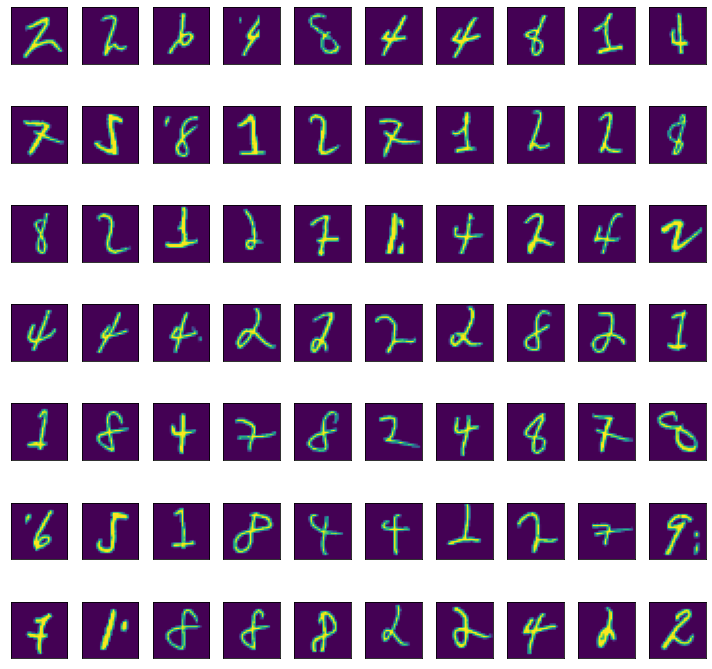

In [21]:
fig, axes = plt.subplots(7, 10, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(outlying_digits[i].reshape((28,28)))
    plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()

# Naive UMAP

<AxesSubplot:>

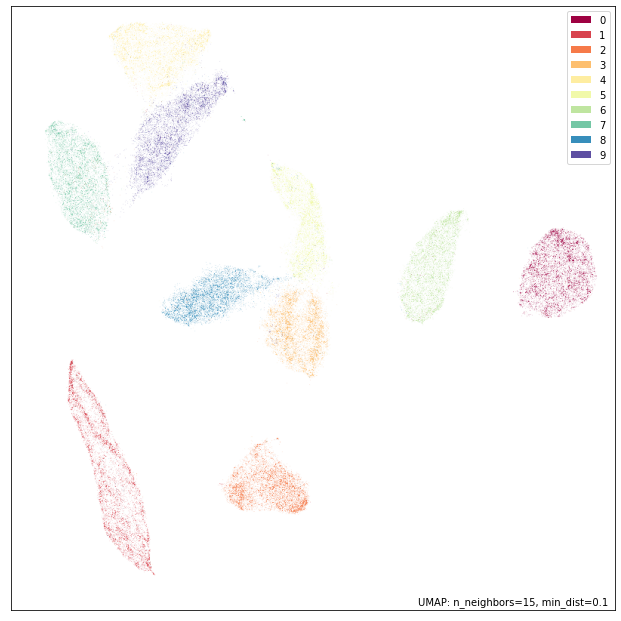

In [7]:
mapper = umap.UMAP().fit(data)
umap.plot.points(mapper, labels=labels)

That looks like what we have come to expect from a UMAP embedding of MNIST. The question is have we managed to preserve outliers well enough that LOF can still find the bizarre digit images, or has the embedding lost that information and contracted the outliers into the individual digit clusters? We can simply apply LOF to the embedding and see what that returns.

In [16]:
%%time
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.001428).fit_predict(mapper.embedding_)
outlying_digits = data[outlier_scores == -1]
outlying_digits.shape

CPU times: user 519 ms, sys: 43.3 ms, total: 562 ms
Wall time: 569 ms


(100, 784)

Now we need to plot the outlying digit images to see what kinds of digit images this approach found to be particularly strange.

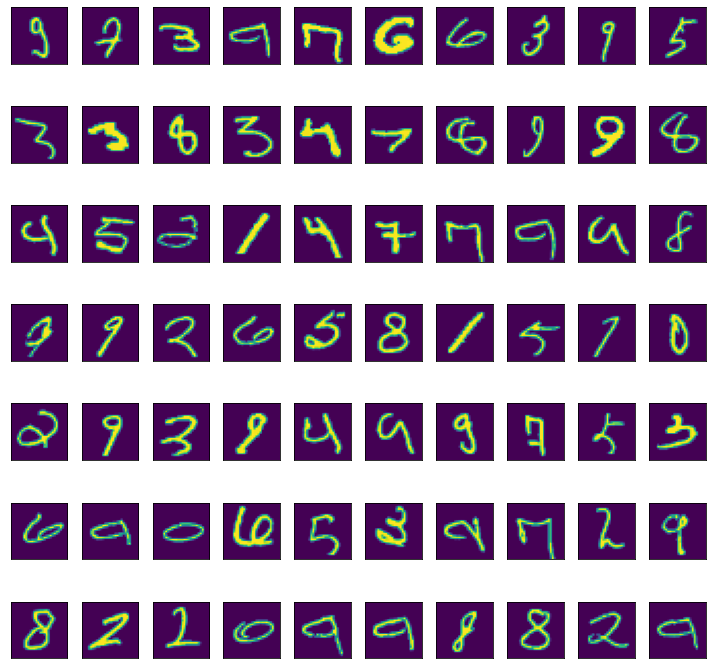

In [11]:
fig, axes = plt.subplots(7, 10, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(outlying_digits[i].reshape((28,28)))
    plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()

In many way this looks to be a better result than the original LOF in the high dimensional space. While the digit images that the high dimensional LOF found to be strange were indeed somewhat odd looking, many of these digit images are considerably stranger – significantly odd line thickness, warped shapes, and images that are hard to even recognise as digits. This helps to demonstrate a certain amount of confirmation bias when examining outliers: since we expect things tagged as outliers to be strange we tend to find aspects of them that justify that classification, potentially unaware of how much stranger some of the data may in fact be. This should make us wary of even this outlier set: what else might lurk in the dataset?

# Tuning with `set_op_mix_ratio`

We can, in fact, potentially improve on this result by tuning the UMAP embedding a little for the task of finding outliers. When UMAP combines together the different local *simplicial sets* the standard approach uses a union, but we could instead take an **intersection**. **An intersection ensures that outliers remain disconnected, which is certainly beneficial when seeking to find outliers.** A downside of the intersection is that it tends to break up the resulting simplicial set into many disconnected components and a lot of the more non-local and global structure is lost, *resulting in a lot lower quality of embedding*. We can, however, *interpolate between the union and intersection*. In UMAP this is given by the set_op_mix_ratio, where a value of `0.0` represents an **intersection**, and a value of `1.0` represents a **union** (the default value is 1.0). By setting this to a lower value, say `0.25`, we can encourage the embedding to do a better job of preserving outliers as outlying, while still retaining the benefits of a union operation.

In [12]:
mapper = umap.UMAP(set_op_mix_ratio=0.25).fit(data)

<AxesSubplot:>

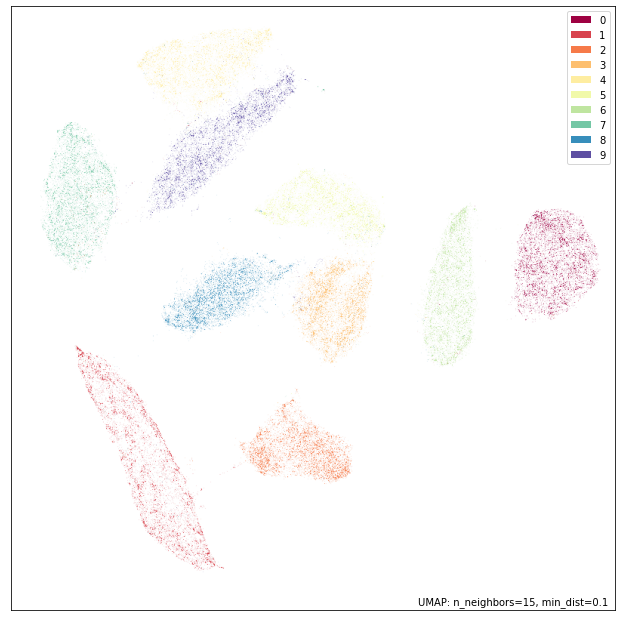

In [13]:
umap.plot.points(mapper, labels=labels)

In [14]:
%%time
outlier_scores = sklearn.neighbors.LocalOutlierFactor(contamination=0.001428).fit_predict(mapper.embedding_)
outlying_digits = data[outlier_scores == -1]
outlying_digits.shape

CPU times: user 556 ms, sys: 235 ms, total: 790 ms
Wall time: 994 ms


(100, 784)

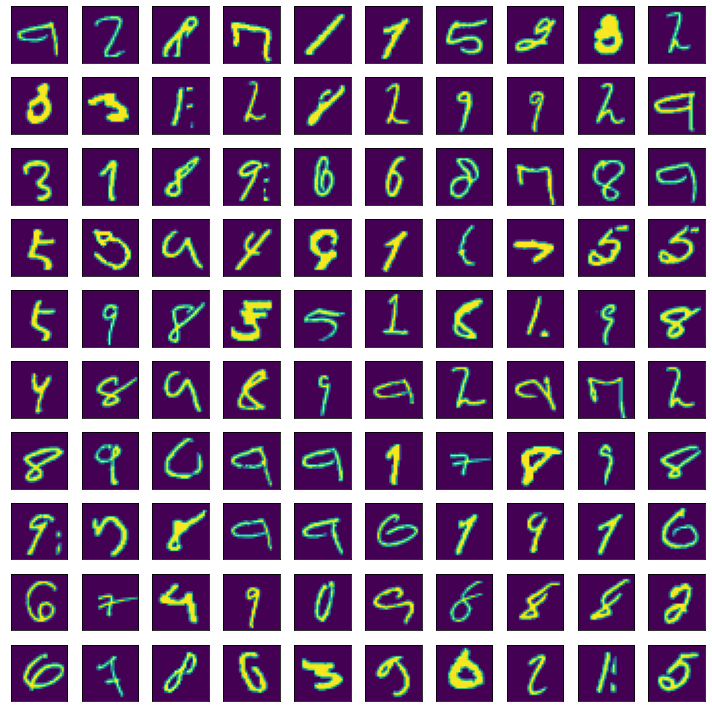

In [15]:
fig, axes = plt.subplots(10, 10, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(outlying_digits[i].reshape((28,28)))
    plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()

Here we see that the line thickness variation (*particularly “fat” digits, or particularly “fine” lines*) that the original embedding helped surface come through even more strongly here. We also see a number of clearly corrupted images with extra lines, dots, or strange blurring occurring.

So, in summary, using UMAP to reduce dimension prior to running classical outlier detection methods such as LOF can improve both the speed with which the algorithm runs, and the quality of results the outlier detection can find. Furthermore we have introduced the `set_op_mix_ratio parameter`, and explained how it can be used to potentially improve the performance of outlier detection approaches applied to UMAP embeddings.